# Data Analysis Script for c57 without father group

## Overview
This Python script analyzes cFos data from experiments on c57 mice reared without father, comparing experimental groups through various metrics, including cell count and energy levels. It uses statistical analyses to identify significant brain areas and creates visualizations to interpret the results.

## Configuration Variables
- `root_directory`: Main directory for data.
- `experiment`: Name of the experiment.
- `experimental_group`: Experimental group.
- `data_directory`: Data directory.
- `subjects`: List of subjects.
- `threshold`: Thresholds for data analysis.

## Analysis and Visualizations

1. **Loading and Preprocessing Data**
   - Loads volumes and data for each subject.
   - Removes areas with null cell counts or no volume.

2. **Dividing Subjects into Experimental Groups**
   - Divides subjects into groups: CONTROL, FATHER URINE EXPOSURE, CD1 URINE EXPOSURE.

3. **Cell Count Analysis**
   - Calculates cell count per area and group.
   - Performs statistical tests to compare groups.
   - Computes and visualizes the cross-correlation matrix for each group.

4. **Energy Analysis**
   - Calculates and compares energy levels per area and group.
   - Performs statistical tests and visualizes cross-correlation matrices.

5. **Visualizations**
   - Creates bar plots and heatmaps to visualize significant differences between experimental groups.

## Additional Notes
- The code is designed to process data stored in CSV files and save them in `.npy` format for analysis.
- Also includes ANOVA tests to compare various metrics between experimental groups.



In [1]:
# !pip install odfpy
# !pip install seaborn
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu

# BLACK WITHOUT FATHER

In [2]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'BL_woF'
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
merged_controls = False
    
subjects = [name for name in os.listdir(data_directory) \
                if os.path.isdir(os.path.join(data_directory, name))]

In [3]:
def find_significant_areas(dictionary, experimental_groups, value, test='mannwhitneyu', alpha=0.05):
    dfs = \
    ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                                  dict_results_across_mice=dictionary, 
                                  value=value)
    df_ttest = ace.test_across_groups(dfs,
                                     test=test,
                                     groups=list(experimental_groups.keys()))
    # sort dataframe pvalues of control vs fam and pick the first 20
    columns = df_ttest.loc[:, df_ttest.columns!='area'].columns
    df_sigareas = pd.DataFrame()
    for col in columns:
        df = df_ttest.sort_values(by=col)[['area', col]]
        df_sigareas = pd.concat([df_sigareas, df[df[col]<alpha]['area'].reset_index(drop=True)], axis=1)
    df_sigareas.columns = [col.replace('pval_', '') for col in columns]
    return df_sigareas

In [4]:
# load query file where we added volumes for each area
volumes = ace.clean_volumes_database()

/home/stella/anaconda2/envs/ClearMap/lib/python3.6/site-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


In [5]:
def load_subject(subject, data_directory, threshold1, threshold2):
    file_suffix = 'cells' + str(threshold2) if subject[0] == 'BL36Fam' else 'cells' + str(threshold1)
    df_mouse = pd.read_csv(data_directory + subject + '/' + file_suffix + '.csv')
    df_mouse = ace.reformat_df_mouse(df=df_mouse)
    
    return df_mouse

In [6]:
# dict_results_across_mice = {subject: ace.calculate_cells_energy_per_level(df_mouse=load_subject(subject=subject, 
#                                                                                                 data_directory=data_directory, 
#                                                                                                 threshold1=2000, 
#                                                                                                 threshold2=1500), 
#                                                                           vol=volumes, 
#                                                                           level=8) for subject in subjects}
# np.save('dict_results/newvolumes/dict_results_across_mice_BL_woF2000_36.npy', dict_results_across_mice)

In [7]:
dict_results_across_mice = np.load('dict_results/newvolumes/dict_results_across_mice_BL_woF2000_36.npy', 
                                   allow_pickle=True).item()

# Rimuovere BL con PMv non attivo

In [8]:
del dict_results_across_mice['BL19Unfam']

In [9]:
dict_results_across_mice.keys()

dict_keys(['BL17Control', 'BL43Fam', 'BL42Unfam', 'BL36Fam', 'BL26Control', 'BL24Fam', 'BL34Fam', 'BL35Unfam', 'BL21Fam', 'BL22Unfam', 'BL39Unfam', 'BL37Fam', 'BL25Unfam', 'BL38Unfam', 'BL23Control', 'BL44Control', 'BL41Control', 'BL31Unfam', 'BL28Unfam', 'BL27Fam', 'BL33Unfam', 'BL29Control', 'BL40Fam', 'BL30Fam', 'BL20Control', 'BL18Fam', 'BL32Control'])

In [10]:
subjects = list(dict_results_across_mice.keys())

In [11]:
subjects

['BL17Control',
 'BL43Fam',
 'BL42Unfam',
 'BL36Fam',
 'BL26Control',
 'BL24Fam',
 'BL34Fam',
 'BL35Unfam',
 'BL21Fam',
 'BL22Unfam',
 'BL39Unfam',
 'BL37Fam',
 'BL25Unfam',
 'BL38Unfam',
 'BL23Control',
 'BL44Control',
 'BL41Control',
 'BL31Unfam',
 'BL28Unfam',
 'BL27Fam',
 'BL33Unfam',
 'BL29Control',
 'BL40Fam',
 'BL30Fam',
 'BL20Control',
 'BL18Fam',
 'BL32Control']

In [12]:
db_null_count = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject].n_cells == 0] for subject in subjects}
db_null_volume = {subject: dict_results_across_mice[subject][
    dict_results_across_mice[subject]['energy'].isnull()] for subject in subjects}
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)


## Calculate number of cells

In [13]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [14]:
df_control_cell_count.set_index('area').sum()

BL17Control    46000
BL26Control    26060
BL23Control    51372
BL44Control    11031
BL41Control    41174
BL29Control    21639
BL20Control    51968
BL32Control    24572
dtype: int64

In [15]:
df_fam_cell_count.set_index('area').sum()

BL43Fam    21042
BL36Fam    15760
BL24Fam    22059
BL34Fam    24774
BL21Fam    42912
BL37Fam    25208
BL27Fam    37634
BL40Fam    32040
BL30Fam    16780
BL18Fam    50231
dtype: int64

In [16]:
df_unfam_cell_count.set_index('area').sum()

BL42Unfam    24109
BL35Unfam    20408
BL22Unfam    56797
BL39Unfam    28628
BL25Unfam    36691
BL38Unfam    64619
BL31Unfam    53989
BL28Unfam    59197
BL33Unfam    20302
dtype: int64

In [17]:
df_control_cell_count.set_index('area').loc['Arcuate hypothalamic nucleus']

BL17Control    27
BL26Control     4
BL23Control     2
BL44Control     0
BL41Control    26
BL29Control    15
BL20Control     1
BL32Control    14
Name: Arcuate hypothalamic nucleus, dtype: int64

In [18]:
df_fam_cell_count.set_index('area').loc['Arcuate hypothalamic nucleus']

BL43Fam    41
BL36Fam     0
BL24Fam     6
BL34Fam    20
BL21Fam     5
BL37Fam    10
BL27Fam    25
BL40Fam    16
BL30Fam     2
BL18Fam     6
Name: Arcuate hypothalamic nucleus, dtype: int64

In [19]:
df_unfam_cell_count.set_index('area').loc['Arcuate hypothalamic nucleus']

BL42Unfam     3
BL35Unfam     7
BL22Unfam    24
BL39Unfam    16
BL25Unfam    17
BL38Unfam    54
BL31Unfam     2
BL28Unfam    34
BL33Unfam    32
Name: Arcuate hypothalamic nucleus, dtype: int64

In [20]:
df_unfam_cell_count.set_index('area').loc['Ventral premammillary nucleus']

BL42Unfam    140
BL35Unfam    196
BL22Unfam    234
BL39Unfam    116
BL25Unfam    147
BL38Unfam    169
BL31Unfam     20
BL28Unfam    153
BL33Unfam    212
Name: Ventral premammillary nucleus, dtype: int64

In [21]:
df_control_cell_count.set_index('area').loc['Supramammillary nucleus']

BL17Control    19
BL26Control    32
BL23Control    91
BL44Control    25
BL41Control    79
BL29Control    80
BL20Control    36
BL32Control    82
Name: Supramammillary nucleus, dtype: int64

In [22]:
df_fam_cell_count.set_index('area').loc['Supramammillary nucleus']

BL43Fam     44
BL36Fam     38
BL24Fam     11
BL34Fam     91
BL21Fam     51
BL37Fam     57
BL27Fam    123
BL40Fam    168
BL30Fam     10
BL18Fam    166
Name: Supramammillary nucleus, dtype: int64

In [23]:
df_unfam_cell_count.set_index('area').loc['Supramammillary nucleus']

BL42Unfam     57
BL35Unfam     25
BL22Unfam    126
BL39Unfam     85
BL25Unfam     76
BL38Unfam     96
BL31Unfam     12
BL28Unfam    115
BL33Unfam     83
Name: Supramammillary nucleus, dtype: int64

In [24]:
df_ttest_ncells = ace.test_across_groups([df_control_cell_count,df_fam_cell_count,df_unfam_cell_count],
                                        test='mannwhitneyu')

In [25]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [26]:
df_ttest_not_null_ncells.set_index("area").loc['Piriform area']

pval_Control_vs_Fam       0.482282
pval_Control_vs_Unfam    0.0679167
pval_Fam_vs_Unfam        0.0654556
Name: Piriform area, dtype: object

In [27]:
find_significant_areas(dictionary=dict_results_across_mice, 
                       experimental_groups=experimental_groups,
                       value='n_cells',
                       test='mannwhitneyu',
                      alpha=0.05)

,Control_vs_Fam,Control_vs_Unfam,Fam_vs_Unfam
0,Accessory olfactory bulb,Ventral premammillary nucleus,Posterior amygdalar nucleus
1,Ventral premammillary nucleus,Cortical amygdalar area,Bed nuclei of the stria terminalis
2,Medial amygdalar nucleus,Periventricular hypothalamic nucleus posterior...,Septohippocampal nucleus
3,Main olfactory bulb,Accessory olfactory bulb,Nucleus of the brachium of the inferior collic...
4,Anteromedial nucleus,Posterior amygdalar nucleus,Cortical amygdalar area
5,Cortical amygdalar area,Medial amygdalar nucleus,Ventral premammillary nucleus
6,Perirhinal area,Piriform-amygdalar area,Triangular nucleus of septum
7,Periventricular hypothalamic nucleus posterior...,Bed nuclei of the stria terminalis,Piriform-amygdalar area
8,Medial preoptic nucleus,Medial preoptic nucleus,Parasubthalamic nucleus
9,Magnocellular nucleus,Tuberomammillary nucleus,Intercalated amygdalar nucleus


In [28]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Accessory olfactory bulb,0.00124686
Ventral premammillary nucleus,0.00291432
Medial amygdalar nucleus,0.0033642
Main olfactory bulb,0.00566599
Anteromedial nucleus,0.0068229
Cortical amygdalar area,0.00927166
Perirhinal area,0.0147447
Periventricular hypothalamic nucleus posterior part,0.017337
Medial preoptic nucleus,0.037554


In [29]:
# sort dataframe pvalues of control vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:40].set_index('area')

,pval_Control_vs_Unfam
area,
Ventral premammillary nucleus,0.000315318
Cortical amygdalar area,0.000317754
Periventricular hypothalamic nucleus posterior part,0.000418448
Accessory olfactory bulb,0.000447194
Posterior amygdalar nucleus,0.000447194
Medial amygdalar nucleus,0.000450468
Piriform-amygdalar area,0.000870606
Bed nuclei of the stria terminalis,0.00121837
Medial preoptic nucleus,0.0016492


In [30]:
# sort dataframe pvalues of fam vs unfam and pick the first 20
df_ttest_not_null_ncells.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:30].set_index('area')

,pval_Fam_vs_Unfam
area,
Posterior amygdalar nucleus,0.00241507
Bed nuclei of the stria terminalis,0.00396802
Septohippocampal nucleus,0.00817311
Nucleus of the brachium of the inferior colliculus,0.00889346
Cortical amygdalar area,0.0123723
Ventral premammillary nucleus,0.0123723
Triangular nucleus of septum,0.0155702
Piriform-amygdalar area,0.0168035
Parasubthalamic nucleus,0.01846


## Calculate corr matrices on number of cells

In [31]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

Text(0.5, 1.0, 'CONTROL')

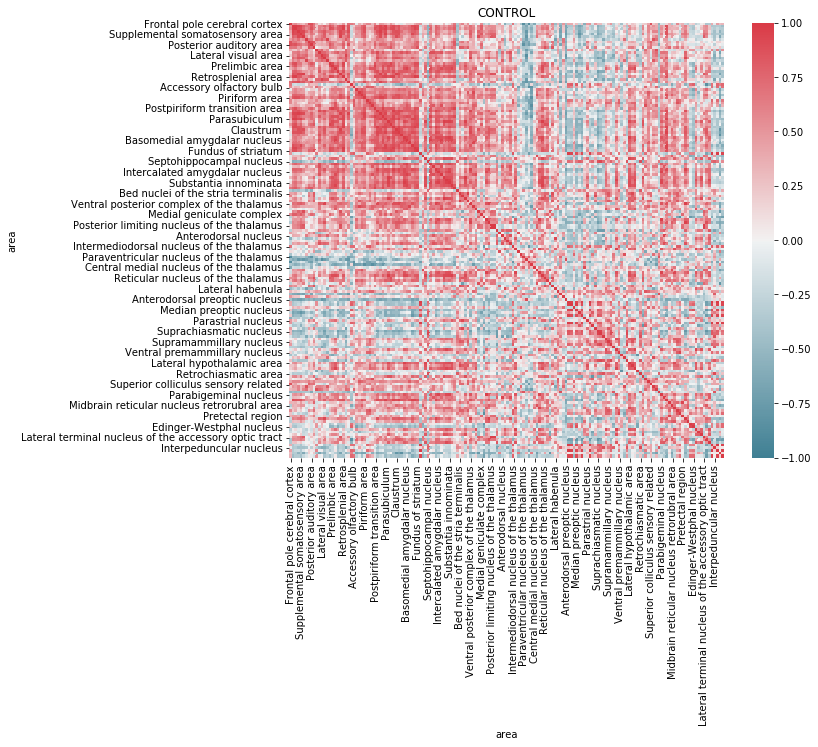

In [32]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

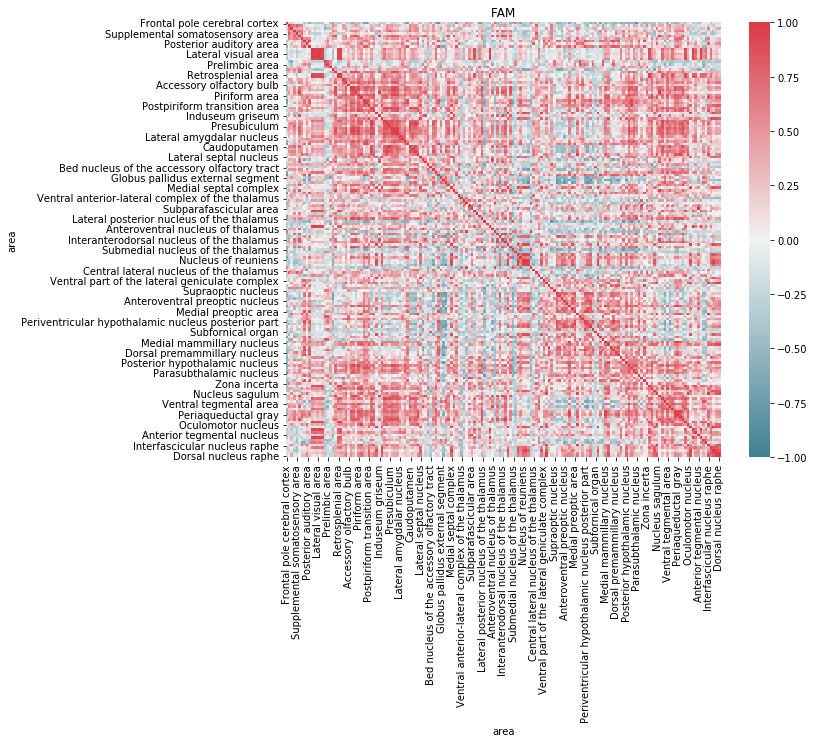

In [33]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

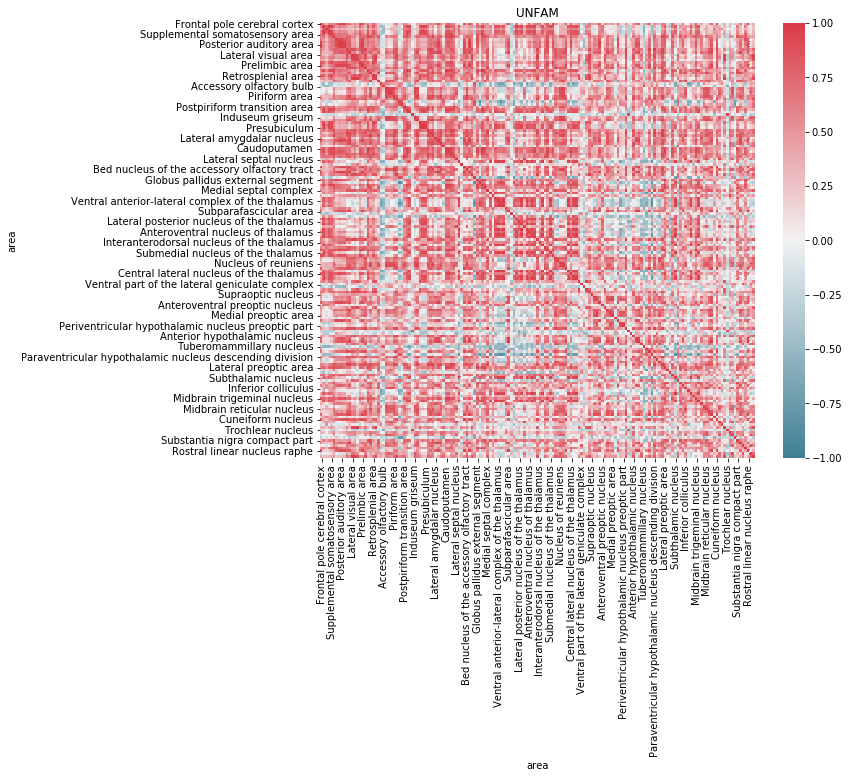

In [34]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_ncells,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

## Calculate energy across experimental groups

In [35]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')

In [36]:
df_ttest_energy = ace.test_across_groups([df_control_energy,df_fam_energy,df_unfam_energy],
                                        test='mannwhitneyu')


In [37]:
# remove rows corresponding to area that have zero cell count across all experimental groups
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [38]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Fam')[['area', 'pval_Control_vs_Fam']][0:20].set_index('area')

,pval_Control_vs_Fam
area,
Accessory olfactory bulb,0.000591163
Ventral premammillary nucleus,0.00566599
Medial amygdalar nucleus,0.00927166
Main olfactory bulb,0.0117338
Anteromedial nucleus,0.0147447
Cortical amygdalar area,0.0183976
Periventricular hypothalamic nucleus posterior part,0.0204442
Perirhinal area,0.0227946
Posterior auditory area,0.0280457


In [39]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Control_vs_Unfam')[['area', 'pval_Control_vs_Unfam']][0:20].set_index('area')

,pval_Control_vs_Unfam
area,
Periventricular hypothalamic nucleus posterior part,0.000450468
Accessory olfactory bulb,0.000450468
Ventral premammillary nucleus,0.000450468
Medial amygdalar nucleus,0.000633085
Cortical amygdalar area,0.000633085
Bed nuclei of the stria terminalis,0.00121837
Piriform-amygdalar area,0.00121837
Posterior amygdalar nucleus,0.00121837
Medial preoptic nucleus,0.00226532


In [40]:
# sort dataframe pvalues of control vs fam and pick the first 20
df_ttest_not_null_energy.sort_values(by='pval_Fam_vs_Unfam')[['area', 'pval_Fam_vs_Unfam']][0:20].set_index('area')

,pval_Fam_vs_Unfam
area,
Bed nuclei of the stria terminalis,0.00109982
Posterior amygdalar nucleus,0.00242438
Septohippocampal nucleus,0.00354272
Triangular nucleus of septum,0.00371199
Intercalated amygdalar nucleus,0.0123723
Ventral premammillary nucleus,0.0123723
Nucleus of the brachium of the inferior colliculus,0.01488
Intercollicular nucleus,0.0152431
Retroethmoid nucleus,0.0152431


In [41]:
corr_matrix_control_energy = ace.cross_corr(df_control_energy)
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)

Text(0.5, 1.0, 'CONTROL')

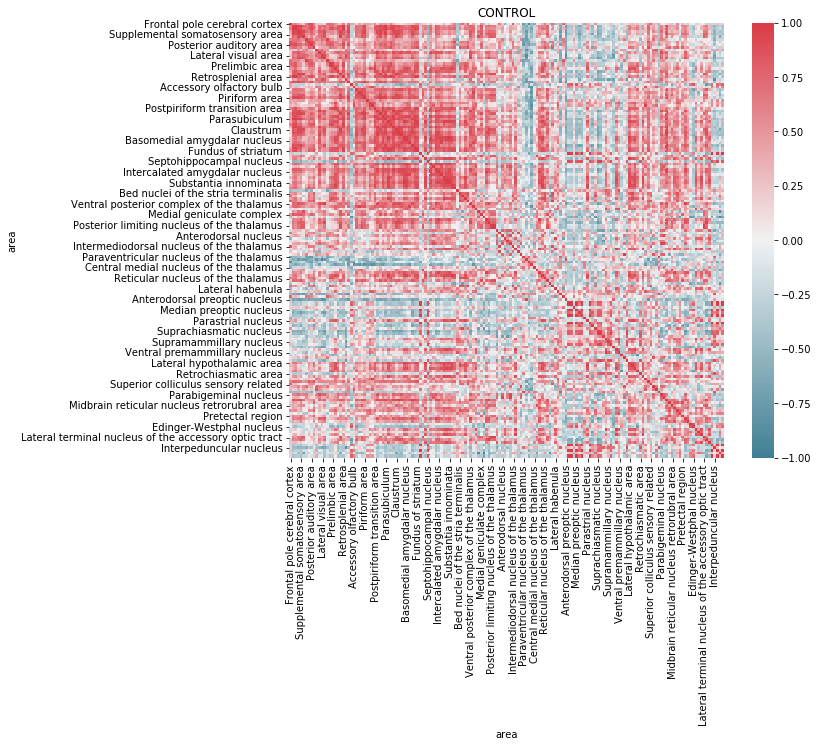

In [42]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_control_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('CONTROL')

Text(0.5, 1.0, 'FAM')

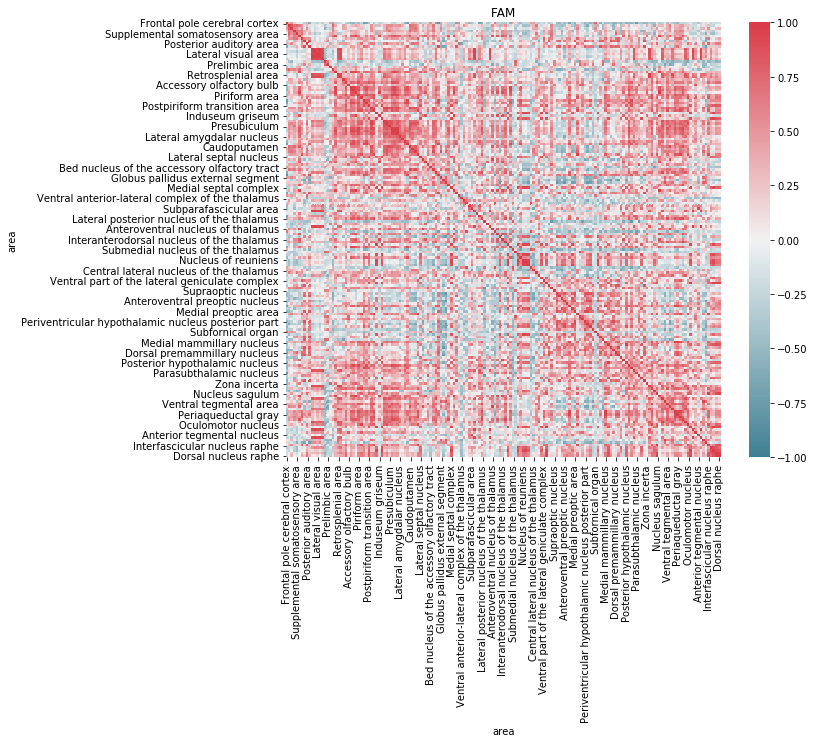

In [43]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_fam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('FAM')

Text(0.5, 1.0, 'UNFAM')

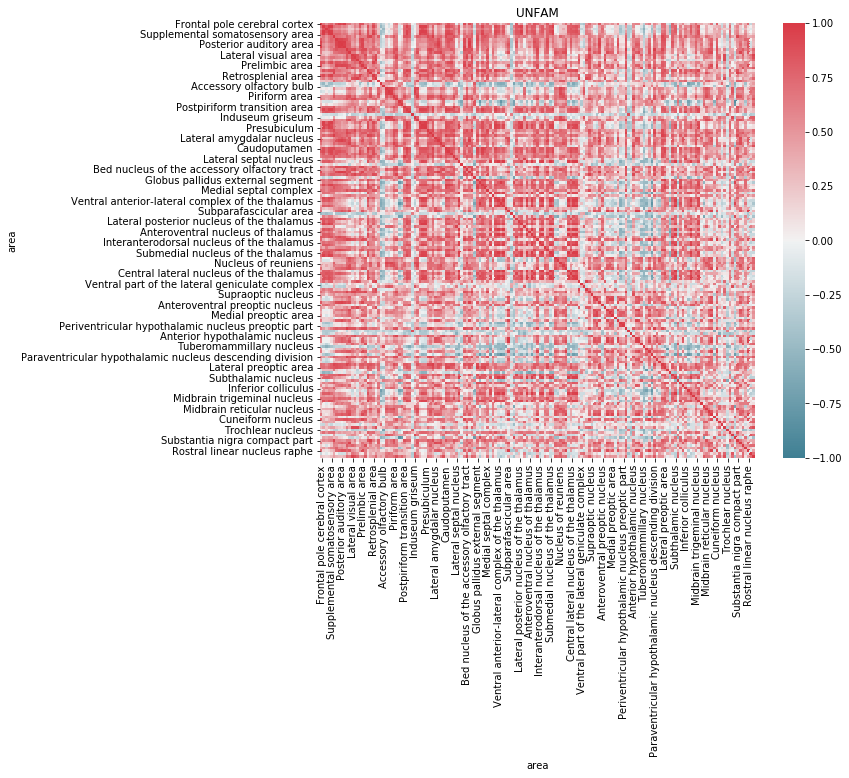

In [44]:
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix_unfam_energy,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)
ax.set_title('UNFAM')

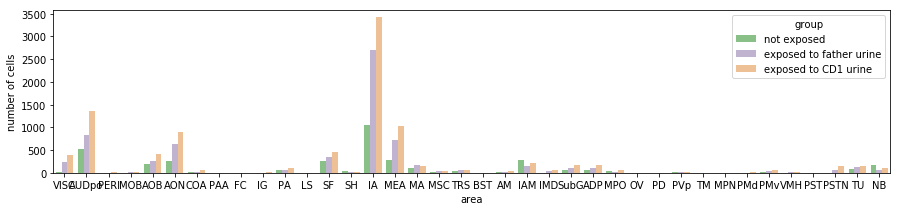

In [45]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Control_vs_Fam']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Control_vs_Unfam']<0.05]['area'].values,
    df_ttest_not_null_ncells[df_ttest_not_null_ncells['pval_Fam_vs_Unfam']<0.05]['area'].values]))

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'number of cells', 'group'])
fam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
unfam = pd.DataFrame(columns=['area', 'number of cells', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['not exposed' for area in areas_ttest]
control['number of cells'] = [df_control_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['exposed to father urine' for area in areas_ttest]
fam['number of cells'] = [df_fam_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['exposed to CD1 urine' for area in areas_ttest]
unfam['number of cells'] = [df_unfam_cell_count.set_index('area').loc[area].mean() for area in areas_ttest]
with_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,3), sharey=True)
sns.barplot(
    data=with_father,
    x="area", y="number of cells", hue="group", palette="Accent", ax=ax)

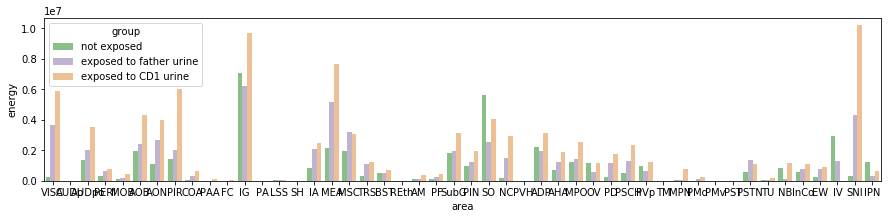

In [46]:
# stack1
areas_ttest = np.unique(np.hstack([
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Control_vs_Fam']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Control_vs_Unfam']<0.05]['area'].values,
    df_ttest_not_null_energy[df_ttest_not_null_energy['pval_Fam_vs_Unfam']<0.05]['area'].values]))

areas_ttest_acronyms = [volumes[volumes['safe_name']==area]['acronym'].values[0] for area in areas_ttest]
areas_ttest_acronyms = [area for area in volumes['acronym'].values if area in areas_ttest_acronyms]

control = pd.DataFrame(columns=['area', 'energy', 'group'])
fam = pd.DataFrame(columns=['area', 'energy', 'group'])
unfam = pd.DataFrame(columns=['area', 'energy', 'group'])
control['area'] = areas_ttest_acronyms
control['group'] = ['not exposed' for area in areas_ttest]
control['energy'] = [df_control_energy.set_index('area').loc[area].mean() for area in areas_ttest]

fam['area'] = areas_ttest_acronyms
fam['group'] = ['exposed to father urine' for area in areas_ttest]
fam['energy'] = [df_fam_energy.set_index('area').loc[area].mean() for area in areas_ttest]

unfam['area'] = areas_ttest_acronyms
unfam['group'] = ['exposed to CD1 urine' for area in areas_ttest]
unfam['energy'] = [df_unfam_energy.set_index('area').loc[area].mean() for area in areas_ttest]
with_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,3), sharey=True)
sns.barplot(
    data=with_father,
    x="area", y="energy", hue="group", palette="Accent", ax=ax)

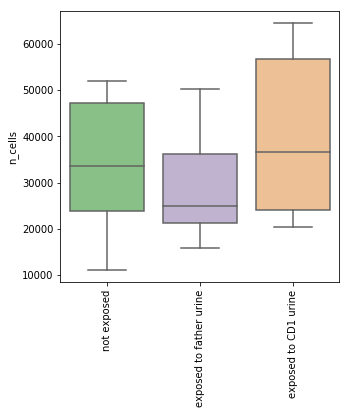

In [47]:
# stack1
subjects = subjects

control = pd.DataFrame(columns=['subject', 'n_cells', 'group'])
fam = pd.DataFrame(columns=['subject', 'n_cells', 'group'])
unfam = pd.DataFrame(columns=['subject', 'n_cells', 'group'])
control['subject'] = [s for s in experimental_groups['Control']]
control['group'] = ['not exposed' for s in experimental_groups['Control']]
control['n_cells'] = [df_control_cell_count.set_index('area').sum()[s] for s in experimental_groups['Control']]

fam['subject'] = [s for s in experimental_groups['Fam']]
fam['group'] = ['exposed to father urine' for s in experimental_groups['Fam']]
fam['n_cells'] = [df_fam_cell_count.set_index('area').sum()[s] for s in experimental_groups['Fam']]

unfam['subject'] = [s for s in experimental_groups['Unfam']]
unfam['group'] = ['exposed to CD1 urine'  for s in experimental_groups['Unfam']]
unfam['n_cells'] = [df_unfam_cell_count.set_index('area').sum()[s] for s in experimental_groups['Unfam']]
with_father = control.append(fam).append(unfam)

f, ax = plt.subplots(ncols=1, nrows=1, figsize=(5,5), sharey=True)
sns.boxplot(
    data=with_father,
    x="group", y="n_cells", palette="Accent", ax=ax)
ax.set_xlabel('')
ax.tick_params(axis='x', labelrotation=90)

In [48]:
d = np.load('dict_results/newvolumes/dict_results_across_mice_BL_woF2000_36.npy', 
                                   allow_pickle=True).item()

In [49]:
animals = list(d.keys())
for k in animals:
    del d[k]
    print(k)
    areas = find_significant_areas(dictionary=d, 
                           experimental_groups=utils.divide_in_exp_groups(list_subjects=d.keys()),
                           value='n_cells',
                           test='mannwhitneyu',
                          alpha=0.05)
    print(areas['Control_vs_Fam'].notna().sum(), 
          areas['Control_vs_Unfam'].notna().sum(), 
          areas['Fam_vs_Unfam'].notna().sum())
    d = np.load('dict_results/newvolumes/dict_results_across_mice_BL_woF2000_36.npy', 
                                       allow_pickle=True).item()

BL17Control
13 35 24
BL43Fam
9 36 21
BL42Unfam
12 37 33
BL36Fam
16 36 16
BL26Control
10 31 24
BL24Fam
14 36 15
BL34Fam
12 36 22
BL35Unfam
12 46 47
BL21Fam
14 36 34
BL22Unfam
12 32 18
BL39Unfam
12 37 28
BL37Fam
11 36 22
BL25Unfam
12 36 28
BL38Unfam
12 29 15
BL23Control
11 39 24
BL44Control
30 29 24
BL41Control
9 35 24
BL31Unfam
12 36 21
BL28Unfam
12 28 17
BL27Fam
12 36 36
BL33Unfam
12 39 35
BL29Control
17 32 24
BL40Fam
11 36 26
BL30Fam
14 36 13
BL20Control
9 32 24
BL18Fam
15 36 32
BL19Unfam
12 31 15
BL32Control
17 34 24


In [50]:
areas['Control_vs_Fam'].notna().sum(), areas['Control_vs_Unfam'].notna().sum(), areas['Fam_vs_Unfam'].notna().sum()

(17, 34, 24)